# Optimize EV Charging Load

**Author:** Eleanor Adachi

**Last updated:** 3/25/2025

**Description:** Run time with 3 combined scenarios and 3 years is ~30 minutes when `alpha = 0.0` (100% weight on grid need) and `Aug_only = False` and ~10 minutes when `alpha = 1.0` (100% weight on net peak) and `Aug_only = True`.

**Note:** Updated to scale up VRE generation over time according to 2023 Preferred System Plan, to use CEC AB 2127 2nd Assessment for the EV charging profiles, and to base EV adoption growth assumptions on CARB's 2020 Mobile Source Strategy. In addition, updated default home (residential) EV charging hours to 7:00 PM - 8:00 AM (overnight) and default workplace/public (commercial) EV charging hours to 9:00 AM - 6:00 PM.

In [55]:
# import packages
import datetime as dt
import itertools
import json
import matplotlib.pyplot as plt
import pandas as pd

from optimize_ev_load import *

In [56]:
# INPUTS

# instruct whether to save results
save_results = True

# run with a smaller sample of feeders
test100 = False

# specify pareto optimization weighting
alpha = 0.0 # alpha is weight for net peak; weight for grid need is 1 - alpha

# include August only
Aug_only = False

# specify limit type (options: 'mn', '10', 'q1', 'md', 'q3', '90', 'mx')
feedlim_type = '90' # will use b (both) by default

# read combined scenarios to include in analysis
with open(r'..\parameters\combined_scenarios_2.json') as json_file:
    combined_sc_dict = json.load(json_file)
# combined_sc_dict = {
# 	"B": {
# 		"_description": "higher home access scenario for EV charging + high scenario for building electrification",
# 		"EVres": 2,
# 		"EVcom": 2, 
# 		"BE": 4
# 	}
# }

# # set up list of years
# # option 1: specify years (see option 2 later)
# yr_ls = [2050]

In [57]:
# read in addload
addload_all = pd.read_csv(r'..\data\addload.csv')

# read in feedlim
feedlim_all = pd.read_csv(r'..\data\feedlim.csv')

# read in baseload
feedload = pd.read_csv(r'..\data\feedload.csv')

# read in vre profile
feedvre = pd.read_csv(r'..\data\feedvre.csv')

# read subrating and subload
subrat = pd.read_csv(r'..\data\subrating.csv')
subload = pd.read_csv(r'..\data\subload.csv')

In [58]:
# test/100_feeders

if test100:
    # read in test feeders
    test_feeders_df = pd.read_csv(r'..\data\test100\test100_feeders.csv')
    
    # filter addload and feedlim to only include feeders in the 100 feeder sample
    addload_all = pd.merge(test_feeders_df, addload_all, how='left', on='feeder_id')
    feedlim_all = pd.merge(test_feeders_df, feedlim_all, how='left', on='feeder_id')
    
    # filter baseload and vre to only include feeders in the 100 feeder sample
    feedload = pd.merge(test_feeders_df, feedload, how='left', on='feeder_id')
    feedvre = pd.merge(test_feeders_df, feedvre, how='left', on='feeder_id')

In [59]:
# option 2: get all unique years in addload
# WARNING - this will overwrite yr_ls defined previously
ldinc_cols = [x for x in list(addload_all.columns) if x.startswith('ldinc')]
yr_ls = list(set(map(lambda x: int(x.split('_')[2]), ldinc_cols)))
yr_ls.sort()

In [60]:
# filter feedlim
feedlim_col = 'limit_b_%s_kw' % feedlim_type
feedlim = feedlim_all[['feeder_id', 'month', 'hour', feedlim_col]]

# rename columns
feedlim = feedlim.rename(columns={feedlim_col: 'limit'})

# create addload_base_cols
addload_base_cols = ['feeder_id', 'month', 'hour', 'mhid']

In [61]:
# initialize newload_all DataFrame
newload_all = pd.DataFrame(columns=['feeder_id', 'month', 'hour', 'mhid'])

# initialize gn_kw_all DataFrame
gn_kw_all = addload_all[['feeder_id']]
gn_kw_all = gn_kw_all.drop_duplicates().reset_index(drop=True)

# initialize subneed_all
subneed_all = pd.DataFrame()

# initialize gnmhid_all DataFrame
gnmhid_all = addload_all[['feeder_id']]
gnmhid_all = gnmhid_all.drop_duplicates().reset_index(drop=True)

# initialize np_kw_dict, for full-year optimization
np_kw_dict = {}

# initialize netload_all
netload_all = pd.DataFrame(columns=['month', 'hour', 'mhid'])

# initialize npmhid_all
npmhid_all = pd.DataFrame()

In [62]:
# start time
start_dt = dt.datetime.now()

# iterate across years and scenarios
for sc_id in combined_sc_dict.keys():
    print('Combined Scenario: ',sc_id)
    for yr in yr_ls:
        print('Year: ',yr)
        
        # select load-scenario dictionary based on combined scenario ID
        load_sc_dict = combined_sc_dict[sc_id]

        # filter & rename columns
        keep_cols = addload_base_cols.copy() # need to copy to "reset" the list
        rename_col_dict = {}
        load_type_ls = list(filter(lambda x: not(x.startswith('_')), load_sc_dict.keys())) # exclude keys that start with underscore
        for load_type in load_type_ls:
            sc_num = load_sc_dict[load_type]
            load_sc_yr_col = f'ldinc_{load_type}{sc_num}_{yr}_kW'
            keep_cols.append(load_sc_yr_col)
            rename_col_dict[load_sc_yr_col] = load_type
        addload = addload_all[ keep_cols ]
        addload = addload.rename(columns=rename_col_dict)
        
        # get list of unique load types
        other_loads = list(set(load_type_ls) - set(['EVres', 'EVcom']))
        # combine other loads
        addload['other'] = addload[ other_loads ].sum(axis=1)
        # drop other loads
        addload = addload.drop(columns=other_loads)

        # make feedvre_year
        solar_yr_col = 'solar_%d_kW' % yr
        wind_yr_col = 'wind_%d_kW' % yr
        feedvre_year = feedvre[['month', 'hour', 'feeder_id', solar_yr_col, wind_yr_col]].copy()
        feedvre_year = feedvre_year.rename(columns={solar_yr_col:'solar_kW', wind_yr_col: 'wind_kW'})

        # create input_df (merge addload, feedlim, feedload, and feedvre; OUTER merge)
        input_df = pd.merge(addload, feedlim, how='outer', on=['feeder_id', 'month', 'hour'])
        input_df = pd.merge(input_df, feedload, how='outer', on=['feeder_id', 'month', 'hour', 'mhid'])
        input_df = pd.merge(input_df, feedvre_year, how='outer', on=['feeder_id', 'month', 'hour'])
        input_df = input_df.rename(columns={'h_kW': 'base'})
        input_df['vre'] = input_df['solar_kW'] + input_df['wind_kW']

        # remove feeders with any NaN values
        input_na_df = pd.isna(input_df.set_index('feeder_id')).sum(axis=1)
        remove_feeders = list(set(input_na_df[ input_na_df > 0 ].index))
        n_removed = len(remove_feeders)
        if test100:
            print('Removing %d feeders: ' % n_removed, remove_feeders) # print number and feeder names
        else:
            print('Removing %d feeders' % n_removed) # print number of feeders only
        removed_df = input_df[ input_df['feeder_id'].isin(remove_feeders) ]
        input_df = input_df[ ~input_df['feeder_id'].isin(remove_feeders) ]

        # limit to Aug
        if Aug_only:
            input_df = input_df[ input_df['month']==8 ]
        
        # create grid need dataframe
        # NOTE: Positive "grid need" means that loads exceed limits (i.e. upgrades required), negative "grid need" means that there is "headroom"
        gn_kw_df = make_gn_kw_df(input_df, opt=False)

        # get np_kw
        if not np_kw_dict: # add status quo if np_kw_dict empty
            np_kw_df = make_np_kw_df(input_df, status_quo=True)
            np_kw_sq = np_kw_df['np_kW'].max()
        np_kw_df = make_np_kw_df(input_df, opt=False)
        np_kw = np_kw_df['np_kW'].max()
        
        # count number of circuits
        feednum = len(input_df['feeder_id'].unique())
        print('Number of feeders included in optimization: ', feednum)
        
        # optimize EV charging
        if alpha == 0.0: # 0% weight on net peak, 100% weight on grid need
            print('Running "global" grid need-minimizing algorithm...')
            output_df, gn_kw_opt_df, gn_mhid_opt_df = minimize_grid_need(input_df)
        elif alpha == 1.0: # 100% weight on net peak, 0% weight on grid need
            print('Running "global" net peak-minimizing algorithm...')
            output_df, np_kw_opt, np_mhid = minimize_net_peak_annual(input_df)
        else:
            raise ValueError('alpha must be 0 or 1')
        
        # get np_kw_opt
        np_kw_opt_df = make_np_kw_df(output_df, opt=True)
        np_kw_opt = np_kw_opt_df['np_kW_opt'].max()
        
        # merge in feedlim and make gn_kw_opt_df
        gn_kw_opt_df = make_gn_kw_df(output_df, opt=True)

        # save to newload, index by sc_id
        newload = output_df[['feeder_id', 'month', 'hour', 'mhid', 'EVres_opt', 'EVcom_opt']]
        # add other load
        newload = pd.merge(newload, addload[['feeder_id', 'mhid', 'other']], how='left', on=['feeder_id', 'mhid'])
        newload = newload.rename(
            columns={
                'EVres_opt': f'ldinc_EVres_{sc_id}_{yr}_kW_opt', 'EVcom_opt': f'ldinc_EVcom_{sc_id}_{yr}_kW_opt',
                'other': f'ldinc_other_{sc_id}_{yr}_kW'
            })
        if newload_all.empty:
            newload_all = newload
        else:
            newload_all = pd.merge(newload_all, newload, how='outer', on=['feeder_id', 'month', 'hour', 'mhid'])

        # create netload_df and save to netload_all
        netload_df = make_netload_df(output_df, feedload, feedvre, include_opt=True)
        netload_df = netload_df.rename(columns={'netload': f'netload_{sc_id}_{yr}_MW', 'netload_opt': f'netload_{sc_id}_{yr}_MW_opt'})
        if netload_all.empty:
            netload_all = netload_df.copy()
        else:
            netload_all = pd.merge(netload_all, netload_df, how='outer', on=['month', 'hour', 'mhid'])
        
        # merge gn_kw_df and gn_kw_opt_df, zero out any negative values and change dtype to float
        gn_kw_df = pd.merge(gn_kw_df, gn_kw_opt_df, how='outer', on='feeder_id')
        gn_kw_df['gn_kW'] = gn_kw_df['gn_kW'].clip(lower=0).astype('float')
        gn_kw_df['gn_kW_opt'] = gn_kw_df['gn_kW_opt'].clip(lower=0).astype('float')
        
        # add gn_kw_df to gn_kw_all
        gn_kw_df = gn_kw_df.rename(columns={'gn_kW': f'gn_{sc_id}_{yr}_kW', 'gn_kW_opt': f'gn_{sc_id}_{yr}_kW_opt'})
        gn_kw_all = pd.merge(gn_kw_all, gn_kw_df, how='outer', on='feeder_id')

        # add to np_kw_dict, for full-year optimization
        if not np_kw_dict: # add status quo if np_kw_dict empty
            np_kw_dict['np_kW'] = np_kw_sq
        np_kw_dict[f'np_{sc_id}_{yr}_kW'] = np_kw
        np_kw_dict[f'np_{sc_id}_{yr}_kW_opt'] = np_kw_opt

        # make gnmhid_df and add gnmhid_df to gnmhid_all
        gnmhid_df = make_gnmhid_df(output_df, feedlim, include_opt=True)
        gnmhid_df = gnmhid_df.rename(columns={'mhid': f'gnmhid_{sc_id}_{yr}', 'mhid_opt': f'gnmhid_{sc_id}_{yr}_opt'})
        gnmhid_all = pd.merge(gnmhid_all, gnmhid_df, how='outer', on='feeder_id')

        # make npmhid_df and add npmhid_df to npmhid_all
        npmhid_df = make_npmhid_df(netload_df)
        if npmhid_all.empty:
            npmhid_all = npmhid_df.copy()
        else:
            npmhid_all = pd.concat([npmhid_all, npmhid_df], axis=1)

        # make subneed_df and add subneed_df to subneed_all
        subneed_df = make_subneed_df(output_df, subrat, subload)
        subneed_df = subneed_df.rename(columns={'subneed': f'subneed_{sc_id}_{yr}_kW', 'subneed_opt': f'subneed_{sc_id}_{yr}_kW_opt'})
        if subneed_all.empty:
            subneed_all = subneed_df.copy()
        else:
            subneed_all = pd.merge(subneed_all, subneed_df, how='outer', on='sub_id')

# end time
end_dt = dt.datetime.now()

print('Elapsed time: ', end_dt - start_dt)

Combined Scenario:  A
Year:  2030
Removing 1155 feeders
Number of feeders included in optimization:  1913
Running "global" grid need-minimizing algorithm...
Year:  2040
Removing 1155 feeders
Number of feeders included in optimization:  1913
Running "global" grid need-minimizing algorithm...
Year:  2050
Removing 1155 feeders
Number of feeders included in optimization:  1913
Running "global" grid need-minimizing algorithm...
Combined Scenario:  B
Year:  2030
Removing 1155 feeders
Number of feeders included in optimization:  1913
Running "global" grid need-minimizing algorithm...
Year:  2040
Removing 1155 feeders
Number of feeders included in optimization:  1913
Running "global" grid need-minimizing algorithm...
Year:  2050
Removing 1155 feeders
Number of feeders included in optimization:  1913
Running "global" grid need-minimizing algorithm...
Combined Scenario:  C
Year:  2030
Removing 1155 feeders
Number of feeders included in optimization:  1913
Running "global" grid need-minimizing al

In [63]:
output_df.head()

,feeder_id,month,hour,mhid,EVres,EVcom,other,limit,l_kW,base,solar_kW,wind_kW,vre,hourly_need,EVres_opt,EVcom_opt
0,12011114,1,0,1.0,1811.762,122.364,1279.031,6760.0,2975.0,3205.0,0.0,817.119413,817.119413,-4007.830,1350.775,122.364
1,12011114,1,1,2.0,1788.412,111.436,1234.734,6830.0,2832.0,3094.0,0.0,809.779010,809.779010,-4107.471,1376.359,111.436
2,12011114,1,2,3.0,1752.730,88.210,1182.855,6890.0,2690.0,2964.0,0.0,793.120063,793.120063,-4214.961,1403.974,88.210
3,12011114,1,3,4.0,1646.189,74.609,1166.493,6910.0,2640.0,2923.0,0.0,777.429109,777.429109,-4254.704,1414.194,74.609
4,12011114,1,4,5.0,1531.269,109.117,1183.254,6880.0,2649.0,2965.0,0.0,744.443325,744.443325,-4190.056,1397.573,109.117


In [64]:
newload_all.tail()

,feeder_id,month,hour,mhid,ldinc_EVres_A_2030_kW_opt,ldinc_EVcom_A_2030_kW_opt,ldinc_other_A_2030_kW,ldinc_EVres_A_2040_kW_opt,ldinc_EVcom_A_2040_kW_opt,ldinc_other_A_2040_kW,...,ldinc_other_B_2050_kW,ldinc_EVres_C_2030_kW_opt,ldinc_EVcom_C_2030_kW_opt,ldinc_other_C_2030_kW,ldinc_EVres_C_2040_kW_opt,ldinc_EVcom_C_2040_kW_opt,ldinc_other_C_2040_kW,ldinc_EVres_C_2050_kW_opt,ldinc_EVcom_C_2050_kW_opt,ldinc_other_C_2050_kW
550939,255451103,12,19,284.0,367.377,50.675,249.248,913.481,126.688,993.055,...,1237.129,315.674,55.378,249.248,785.859,138.446,993.055,1241.879,221.513,1237.129
550940,255451103,12,20,285.0,365.600,32.034,243.298,910.669,80.084,969.350,...,1207.597,313.815,34.130,243.298,782.512,85.326,969.350,1241.123,136.522,1207.597
550941,255451103,12,21,286.0,365.025,19.784,247.801,910.088,49.460,987.289,...,1229.945,313.090,19.296,247.801,781.564,48.241,987.289,1240.477,77.185,1229.945
550942,255451103,12,22,287.0,362.474,15.740,238.635,906.650,39.351,950.770,...,1184.451,310.644,14.664,238.635,777.815,36.660,950.770,1238.258,58.656,1184.451
550943,255451103,12,23,288.0,358.517,8.521,217.489,898.631,21.302,866.521,...,1079.495,307.058,8.815,217.489,769.833,22.038,866.521,1231.687,35.260,1079.495


In [65]:
gn_kw_all.tail()

,feeder_id,gn_A_2030_kW,gn_A_2030_kW_opt,gn_A_2040_kW,gn_A_2040_kW_opt,gn_A_2050_kW,gn_A_2050_kW_opt,gn_B_2030_kW,gn_B_2030_kW_opt,gn_B_2040_kW,gn_B_2040_kW_opt,gn_B_2050_kW,gn_B_2050_kW_opt,gn_C_2030_kW,gn_C_2030_kW_opt,gn_C_2040_kW,gn_C_2040_kW_opt,gn_C_2050_kW,gn_C_2050_kW_opt
3050,255391101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3051,255391102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3052,255391103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3053,255451102,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,66.779,0.000,0.0,0.0,0.000,0.000,0.000,0.000
3054,255451103,0.0,0.0,869.554,587.632,2046.367,1337.473,0.0,0.0,1010.685,598.922,2272.177,1355.537,0.0,0.0,723.308,549.113,1812.373,1275.844


In [66]:
subneed_all.tail()

,sub_id,subneed_A_2030_kW,subneed_A_2030_kW_opt,subneed_A_2040_kW,subneed_A_2040_kW_opt,subneed_A_2050_kW,subneed_A_2050_kW_opt,subneed_B_2030_kW,subneed_B_2030_kW_opt,subneed_B_2040_kW,subneed_B_2040_kW_opt,subneed_B_2050_kW,subneed_B_2050_kW_opt,subneed_C_2030_kW,subneed_C_2030_kW_opt,subneed_C_2040_kW,subneed_C_2040_kW_opt,subneed_C_2050_kW,subneed_C_2050_kW_opt
579,25529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
580,25532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581,25536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
582,25537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583,25545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# for full-year optimization
np_kw_all = pd.DataFrame.from_dict(np_kw_dict, orient='index', columns=['kW'])
np_kw_all = np_kw_all.T
np_kw_all

,np_kW,np_A_2030_kW,np_A_2030_kW_opt,np_A_2040_kW,np_A_2040_kW_opt,np_A_2050_kW,np_A_2050_kW_opt,np_B_2030_kW,np_B_2030_kW_opt,np_B_2040_kW,np_B_2040_kW_opt,np_B_2050_kW,np_B_2050_kW_opt,np_C_2030_kW,np_C_2030_kW_opt,np_C_2040_kW,np_C_2040_kW_opt,np_C_2050_kW,np_C_2050_kW_opt
kW,9.656247e+06,1.097884e+07,1.137646e+07,1.362114e+07,1.432253e+07,1.515577e+07,1.589138e+07,1.098240e+07,1.142334e+07,1.363003e+07,1.439045e+07,1.558075e+07,1.599716e+07,1.098761e+07,1.133707e+07,1.364307e+07,1.425923e+07,1.493429e+07,1.579690e+07


In [68]:
netload_all.head()

,month,hour,mhid,netload_A_2030_MW,netload_A_2030_MW_opt,netload_A_2040_MW,netload_A_2040_MW_opt,netload_A_2050_MW,netload_A_2050_MW_opt,netload_B_2030_MW,...,netload_B_2040_MW,netload_B_2040_MW_opt,netload_B_2050_MW,netload_B_2050_MW_opt,netload_C_2030_MW,netload_C_2030_MW_opt,netload_C_2040_MW,netload_C_2040_MW_opt,netload_C_2050_MW,netload_C_2050_MW_opt
0,1,0,1.0,5808.933662,5514.600080,8137.408694,7426.104930,9981.054080,8876.142385,5962.508687,...,8521.346165,7691.253314,10595.354030,9301.064802,5661.193303,5415.849307,7768.057817,7173.926898,9390.092640,8467.869691
1,1,1,2.0,5508.719723,5239.139534,7746.599393,7113.733262,9539.308660,8559.894127,5658.142268,...,8120.155567,7388.108236,10136.998609,8998.308335,5367.442957,5138.794900,7393.407268,6855.150747,8974.201356,8142.293815
2,1,2,3.0,5228.421539,4987.103933,7378.109079,6834.587964,9116.105833,8284.341153,5373.646541,...,7741.171707,7117.876578,9697.005922,8735.424410,5088.009352,4882.295880,7027.078632,6562.216172,8554.457043,7845.898768
3,1,3,4.0,5013.249862,4839.660378,7034.142009,6672.626254,8660.984420,8123.695931,5146.762947,...,7367.924763,6962.600861,9195.036895,8584.462455,4887.253521,4733.566798,6719.151238,6395.261988,8156.999219,7677.582531
4,1,4,5.0,4960.636391,4855.145759,6905.939011,6716.976482,8447.058160,8183.513386,5073.980590,...,7189.299430,7002.617220,8900.434862,8637.139066,4851.043063,4750.348229,6631.955694,6442.615510,8008.684858,7742.439856


In [69]:
npmhid_all

,npmhid_A_2030,npmhid_A_2030_opt,npmhid_A_2040,npmhid_A_2040_opt,npmhid_A_2050,npmhid_A_2050_opt,npmhid_B_2030,npmhid_B_2030_opt,npmhid_B_2040,npmhid_B_2040_opt,npmhid_B_2050,npmhid_B_2050_opt,npmhid_C_2030,npmhid_C_2030_opt,npmhid_C_2040,npmhid_C_2040_opt,npmhid_C_2050,npmhid_C_2050_opt
mhid,188.0,188.0,188.0,188.0,190.0,188.0,188.0,188.0,188.0,188.0,190.0,188.0,188.0,188.0,188.0,188.0,188.0,188.0


Plot for most recent run (combined scenario C in year 2050) only...


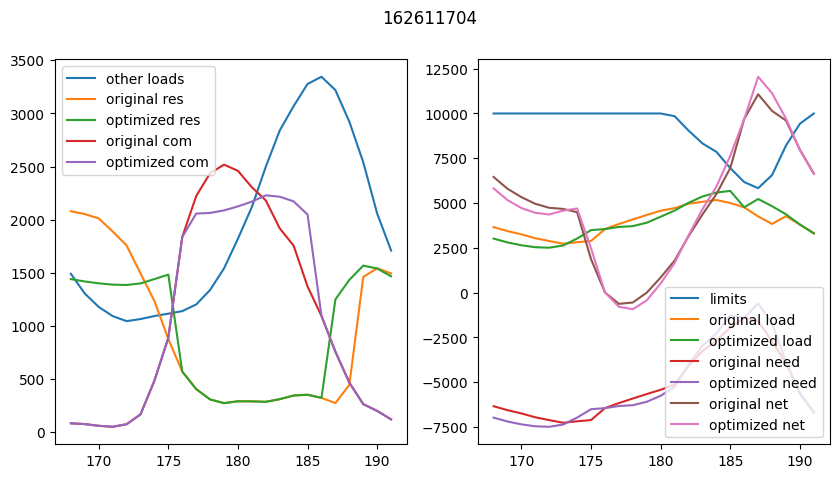

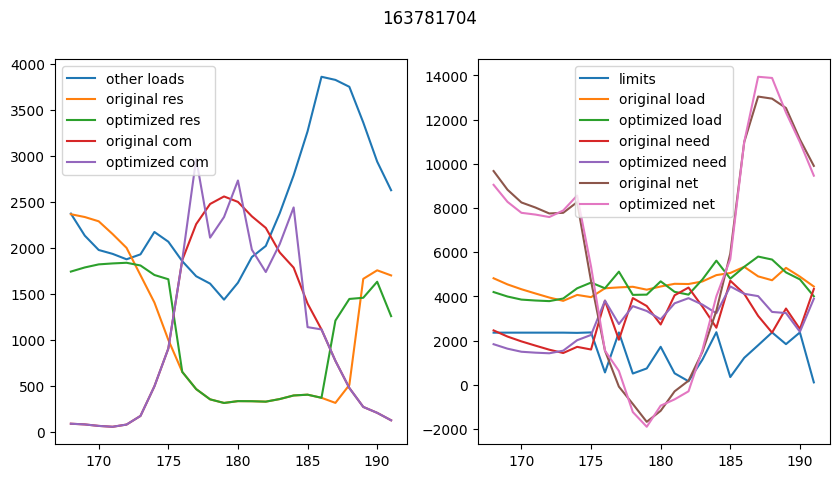

In [70]:
# make plots
print('Plot for most recent run (combined scenario %s in year %d) only...' % (sc_id, yr) )

plot_df = output_df.copy()
plot_df['hourly_net'] = plot_df['base'] + plot_df['EVres'] + plot_df['EVcom'] + plot_df['other'] - plot_df['vre']
plot_df['hourly_net_opt'] = plot_df['base'] + plot_df['EVres_opt'] + plot_df['EVcom_opt'] + plot_df['other'] - plot_df['vre']
plot_df['hourly_need'] = plot_df['EVres'] + plot_df['EVcom'] + plot_df['other'] - plot_df['limit']
plot_df['hourly_need_opt'] = plot_df['EVres_opt'] + plot_df['EVcom_opt'] + plot_df['other'] - plot_df['limit']
plot_df['add_kw'] = plot_df['EVres'] + plot_df['EVcom'] + plot_df['other']
plot_df['add_kw_opt'] = plot_df['EVres_opt'] + plot_df['EVcom_opt'] + plot_df['other']

# plot_feeders = list(plot_df.feeder_id.unique())[20:25]
plot_feeders = [162611704, 163781704]

if Aug_only:
    month = 1 # if August only, use month=1
else:
    month = 8
start_iloc = (month-1)*24
plot_range = range(start_iloc, start_iloc+24)

for feeder in plot_feeders:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    plot_df0 = plot_df[ plot_df.feeder_id == feeder ]

    fig.suptitle(feeder)

    ax1.plot(plot_range, plot_df0.other.iloc[plot_range], label='other loads')
    ax1.plot(plot_range, plot_df0.EVres.iloc[plot_range], label='original res')
    ax1.plot(plot_range, plot_df0.EVres_opt.iloc[plot_range], label='optimized res')
    ax1.plot(plot_range, plot_df0.EVcom.iloc[plot_range], label='original com')
    ax1.plot(plot_range, plot_df0.EVcom_opt.iloc[plot_range], label='optimized com')
    ax1.legend()
    
    ax2.plot(plot_range, plot_df0.limit.iloc[plot_range], label='limits')
    ax2.plot(plot_range, plot_df0.add_kw.iloc[plot_range], label='original load')
    ax2.plot(plot_range, plot_df0.add_kw_opt.iloc[plot_range], label='optimized load')
    ax2.plot(plot_range, plot_df0.hourly_need.iloc[plot_range], label='original need')
    ax2.plot(plot_range, plot_df0.hourly_need_opt.iloc[plot_range], label='optimized need')
    ax2.plot(plot_range, plot_df0.hourly_net.iloc[plot_range], label='original net')
    ax2.plot(plot_range, plot_df0.hourly_net_opt.iloc[plot_range], label='optimized net')
    ax2.legend()
    
    plt.show()

In [71]:
print(len(removed_df))
removed_df.head()

332928


,feeder_id,month,hour,mhid,EVres,EVcom,other,limit,l_kW,base,solar_kW,wind_kW,vre
0,12011101,1,0,1.0,8.081,61.182,0.0,4820.0,NaN,NaN,NaN,NaN,NaN
1,12011101,1,1,2.0,7.977,55.718,0.0,4900.0,NaN,NaN,NaN,NaN,NaN
2,12011101,1,2,3.0,7.818,44.105,0.0,4980.0,NaN,NaN,NaN,NaN,NaN
3,12011101,1,3,4.0,7.343,37.304,0.0,4550.0,NaN,NaN,NaN,NaN,NaN
4,12011101,1,4,5.0,6.830,54.558,0.0,4710.0,NaN,NaN,NaN,NaN,NaN


In [72]:
# save results
np_pct = int(round(alpha*100, 0))
gn_pct = 100 - np_pct
ft = feedlim_type

if save_results:
    if test100:
        check = check_dir(r'..\results\test100\gn%d_np%d' % (gn_pct, np_pct), mkdir=True)
        if Aug_only:
            newload_all.to_csv(fr'..\results\test100\gn{gn_pct}_np{np_pct}\newload_gn{gn_pct}_np{np_pct}_{ft}_test100_Aug.csv', index=False)
            gn_kw_all.to_csv(fr'..\results\test100\gn{gn_pct}_np{np_pct}\gridneed_gn{gn_pct}_np{np_pct}_{ft}_test100_Aug.csv', index=False)
            subneed_all.to_csv(fr'..\results\test100\gn{gn_pct}_np{np_pct}\subneed_gn{gn_pct}_np{np_pct}_{ft}_test100_Aug.csv', index=False)
            np_kw_all.to_csv(fr'..\results\test100\gn{gn_pct}_np{np_pct}\netpeak_gn{gn_pct}_np{np_pct}_{ft}_test100_Aug.csv', index=False)
            netload_all.to_csv(fr'..\results\test100\gn{gn_pct}_np{np_pct}\netload_gn{gn_pct}_np{np_pct}_{ft}_test100_Aug.csv', index=False)
            gnmhid_all.to_csv(fr'..\results\test100\gn{gn_pct}_np{np_pct}\gnmhid_gn{gn_pct}_np{np_pct}_{ft}_test100_Aug.csv', index=False)
            npmhid_all.to_csv(fr'..\results\test100\gn{gn_pct}_np{np_pct}\npmhid_gn{gn_pct}_np{np_pct}_{ft}_test100_Aug.csv', index=False)
        else:
            newload_all.to_csv(fr'..\results\test100\gn{gn_pct}_np{np_pct}\newload_gn{gn_pct}_np{np_pct}_{ft}_test100.csv', index=False)
            gn_kw_all.to_csv(fr'..\results\test100\gn{gn_pct}_np{np_pct}\gridneed_gn{gn_pct}_np{np_pct}_{ft}_test100.csv', index=False)
            subneed_all.to_csv(fr'..\results\test100\gn{gn_pct}_np{np_pct}\subneed_gn{gn_pct}_np{np_pct}_{ft}_test100.csv', index=False)
            np_kw_all.to_csv(fr'..\results\test100\gn{gn_pct}_np{np_pct}\netpeak_gn{gn_pct}_np{np_pct}_{ft}_test100.csv', index=False)
            netload_all.to_csv(fr'..\results\test100\gn{gn_pct}_np{np_pct}\netload_gn{gn_pct}_np{np_pct}_{ft}_test100.csv', index=False)
            gnmhid_all.to_csv(fr'..\results\test100\gn{gn_pct}_np{np_pct}\gnmhid_gn{gn_pct}_np{np_pct}_{ft}_test100.csv', index=False)
            npmhid_all.to_csv(fr'..\results\test100\gn{gn_pct}_np{np_pct}\npmhid_gn{gn_pct}_np{np_pct}_{ft}_test100.csv', index=False)
    else:
        check = check_dir(r'..\results\gn%d_np%d' % (gn_pct, np_pct), mkdir=True)
        if Aug_only:
            newload_all.to_csv(fr'..\results\gn{gn_pct}_np{np_pct}\newload_gn{gn_pct}_np{np_pct}_{ft}_Aug.csv', index=False)
            gn_kw_all.to_csv(fr'..\results\gn{gn_pct}_np{np_pct}\gridneed_gn{gn_pct}_np{np_pct}_{ft}_Aug.csv', index=False)
            subneed_all.to_csv(fr'..\results\gn{gn_pct}_np{np_pct}\subneed_gn{gn_pct}_np{np_pct}_{ft}_Aug.csv', index=False)
            np_kw_all.to_csv(fr'..\results\gn{gn_pct}_np{np_pct}\netpeak_gn{gn_pct}_np{np_pct}_{ft}_Aug.csv', index=False)
            netload_all.to_csv(fr'..\results\gn{gn_pct}_np{np_pct}\netload_gn{gn_pct}_np{np_pct}_{ft}_Aug.csv', index=False)
            gnmhid_all.to_csv(fr'..\results\gn{gn_pct}_np{np_pct}\gnmhid_gn{gn_pct}_np{np_pct}_{ft}_Aug.csv', index=False)
            npmhid_all.to_csv(fr'..\results\gn{gn_pct}_np{np_pct}\npmhid_gn{gn_pct}_np{np_pct}_{ft}_Aug.csv', index=False)
        else:
            newload_all.to_csv(fr'..\results\gn{gn_pct}_np{np_pct}\newload_gn{gn_pct}_np{np_pct}_{ft}.csv', index=False)
            gn_kw_all.to_csv(fr'..\results\gn{gn_pct}_np{np_pct}\gridneed_gn{gn_pct}_np{np_pct}_{ft}.csv', index=False)
            subneed_all.to_csv(fr'..\results\gn{gn_pct}_np{np_pct}\subneed_gn{gn_pct}_np{np_pct}_{ft}.csv', index=False)
            np_kw_all.to_csv(fr'..\results\gn{gn_pct}_np{np_pct}\netpeak_gn{gn_pct}_np{np_pct}_{ft}.csv', index=False)
            netload_all.to_csv(fr'..\results\gn{gn_pct}_np{np_pct}\netload_gn{gn_pct}_np{np_pct}_{ft}.csv', index=False)
            gnmhid_all.to_csv(fr'..\results\gn{gn_pct}_np{np_pct}\gnmhid_gn{gn_pct}_np{np_pct}_{ft}.csv', index=False)
            npmhid_all.to_csv(fr'..\results\gn{gn_pct}_np{np_pct}\npmhid_gn{gn_pct}_np{np_pct}_{ft}.csv', index=False)